In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Preparations
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
%run ../../core/aeff_calculations.py


# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py



# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.
icecube (full) astro events: 2842.6720003089413
Below -4.59 deg, A_eff is set to 0
starting aeff rotations
Saving up-going effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_upgoing.pckl
starting full effective area calculation...
Saving full effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_full.pckl
finished!
args: Namespace(renew_calc=False, kde=False)
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins


# Imports

In [3]:
import pickle
from os.path import join

import numpy as np
from matplotlib.colors import LogNorm
from settings import *  # contains all flux parameters


# Default binning

In [4]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
101 -1.0 1.0


# Get the effective area
The PLEnuM effective area is calculated in core/aeff_calculations.py

In [20]:
from aeff_calculations import read_effective_area

## original Aeff from the data release

In [21]:
public_data_aeff = read_effective_area()
# log10(E_nu/GeV)_min log10(E_nu/GeV)_max
# Dec_nu_min[deg] Dec_nu_max[deg]
# A_Eff[cm^2]

# the file contains all bin edges

sindec_bins = np.unique(
    np.sin(np.deg2rad([public_data_aeff.Dec_nu_min, public_data_aeff.Dec_nu_max]))
)
sindec_bins = np.round(sindec_bins, 2)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

log_ebins = np.unique([public_data_aeff.logE_nu_min, public_data_aeff.logE_nu_max])
ebins = np.power(10, log_ebins)
emids = np.power(10, get_mids(log_ebins))
ewidth = np.diff(ebins)

# re-shape into 2D array with (A(E) x A(delta))
# and switch the eff area ordering
aeff_icecube_full = (
    public_data_aeff["A_eff"].values.reshape(len(sindec_mids), len(emids)).T
)

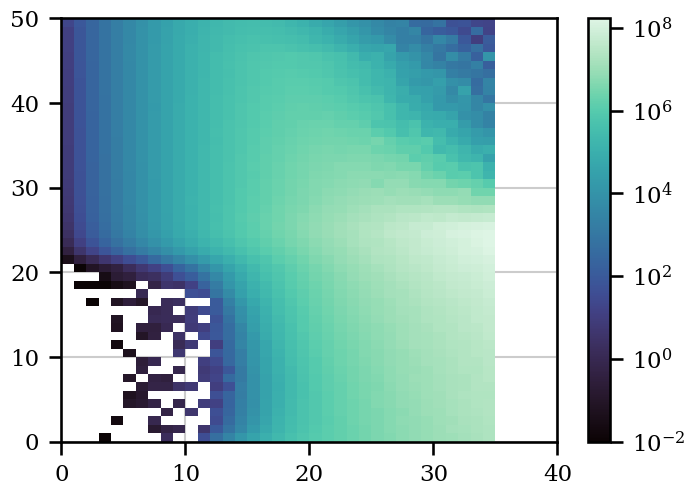

In [23]:
plt.pcolormesh(aeff_icecube_full.T, norm=LogNorm())
plt.colorbar()

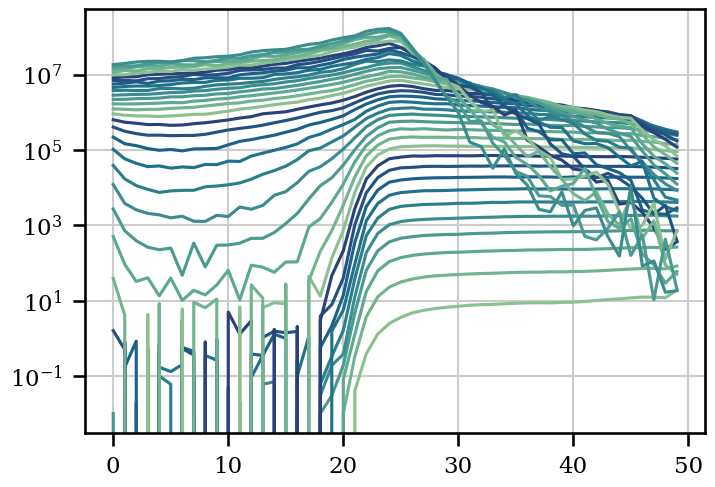

In [26]:
_ = plt.plot(aeff_icecube_full.T)
plt.yscale("log")

## re-binned aeff

In [5]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])

with open(join(LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d_full = pickle.load(f)

dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.79644727 13.79644727 17.18709663 ... 75.41675658 16.92327606
  13.05294825]
 [17.35308647 17.35308647 20.90399148 ... 37.62945651 16.55571564
  12.76944835]
 [19.15324098 19.15324098 22.78536074 ... 18.48681666 16.46008672
  12.69568961]]


## 2D effective area plot in log(energy) and sin(decl)

In [6]:
from matplotlib.colors import ListedColormap, LogNorm
cmap = ListedColormap(sns.color_palette("mako", n_colors=12))

### up-going effective area

9.483826757161751e-05


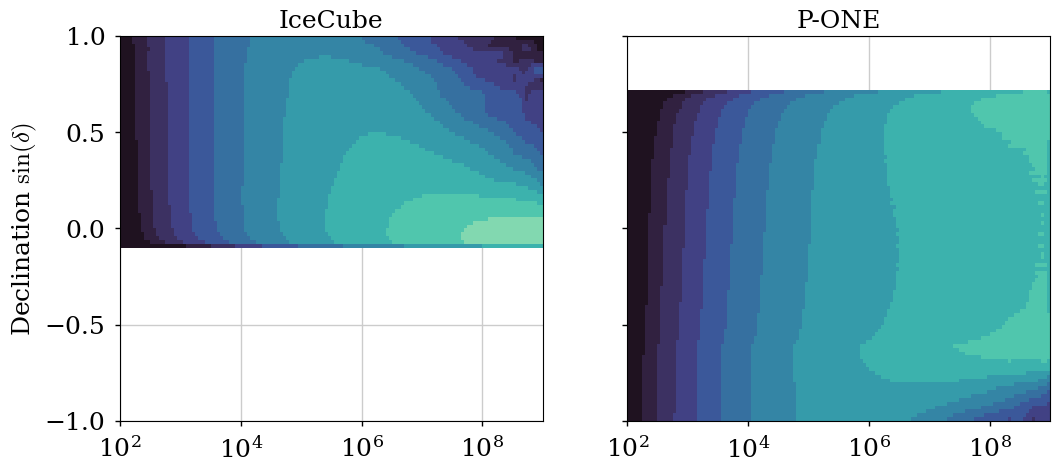

In [7]:
# IceCube and P-ONE only
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,

)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"P-ONE")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["P-ONE"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,

)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

print(np.sum(aeff_2d["IceCube"])/np.sum(aeff_2d["P-ONE"])-1)

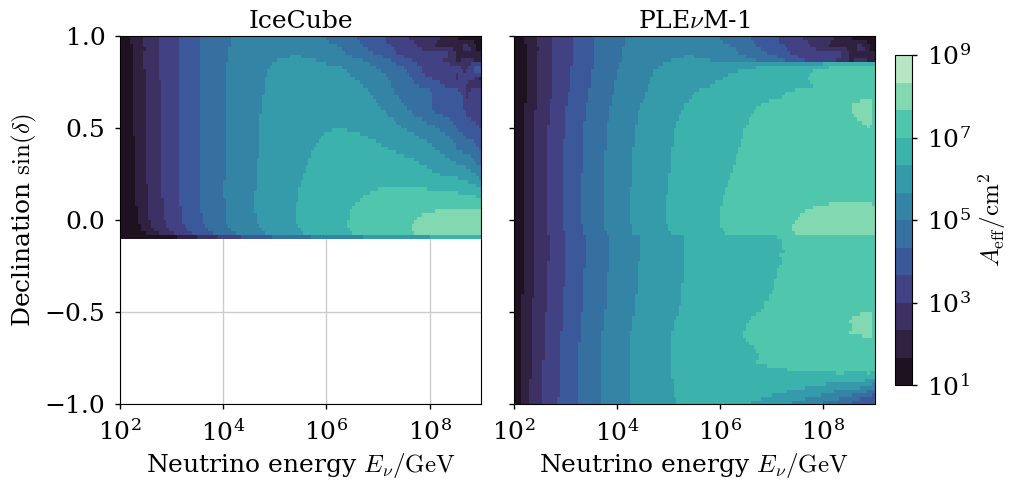

In [8]:
# horizontal
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,

)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-1"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,

)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_upgoing_comparison_IC_PLENUM-1.pdf"))


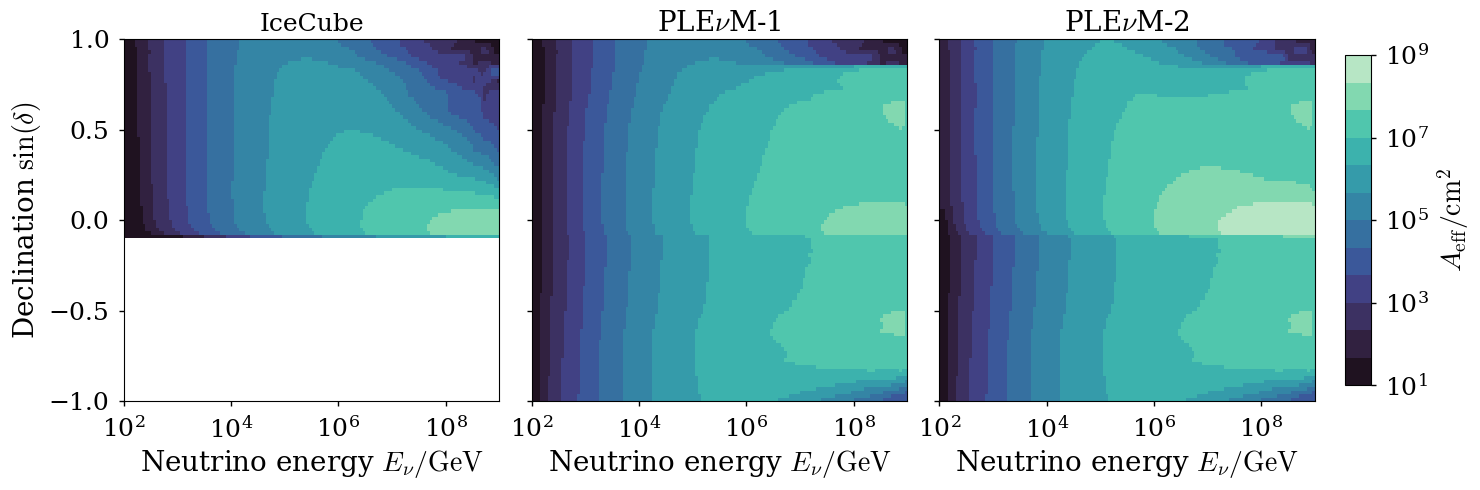

In [9]:
# IceCube, Plenum-1 and 2
# horizontal
fontsize = 20
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0, # remove gridlines in some pdf viewers
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$", fontsize=fontsize)

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1", fontsize=fontsize)
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-1"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2", fontsize=fontsize)
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-2"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$", fontsize=fontsize)
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$", fontsize=fontsize)
fig.subplots_adjust(right=0.88)
axes[0].grid(False)
fig.savefig(join(BASEPATH, "plots/aeff_upgoing_comparison_IC_PLENUM-1-2.pdf"))

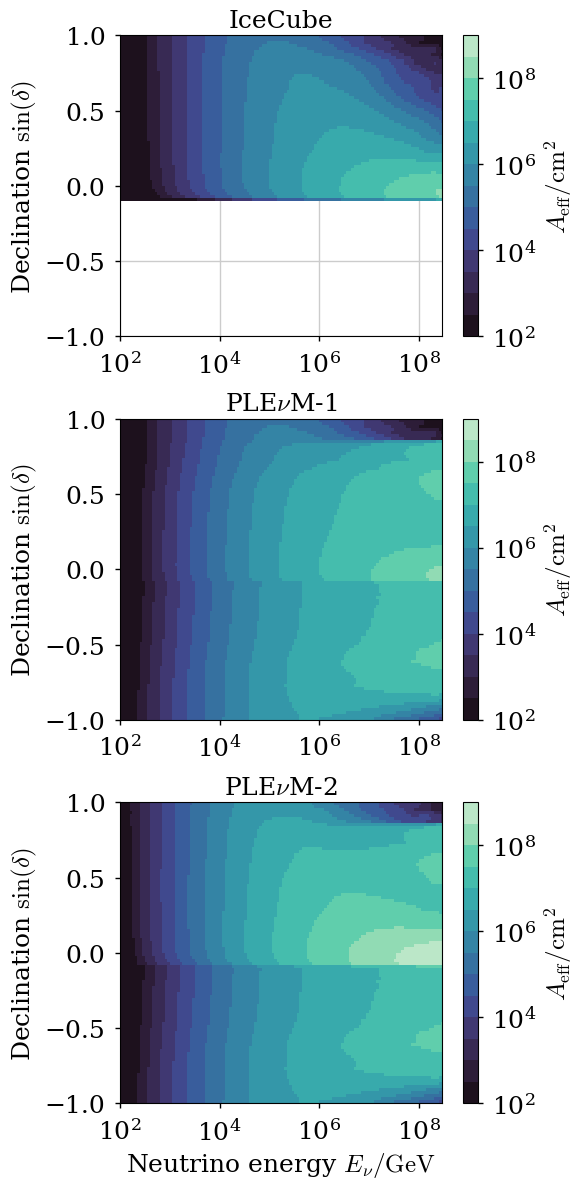

In [10]:
# vertical plot
cmap = ListedColormap(sns.color_palette("mako", n_colors=14))
log_col = LogNorm(
        vmin=1e2,
        vmax=1e9,
    )
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].histo,
    norm=log_col,
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 3e8)

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-1"].histo,
    norm=log_col,
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 3e8)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-2"].histo,
    norm=log_col,
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 3e8)
ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")

for ax in axes:
    ax.set_ylabel(r"Declination $\sin(\delta)$")
    
fig.tight_layout()
# # (left, bottom, width, height)
# cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_upgoing_comparison_IC_PLENUM-1-2_vertical.pdf"))


### full effective area

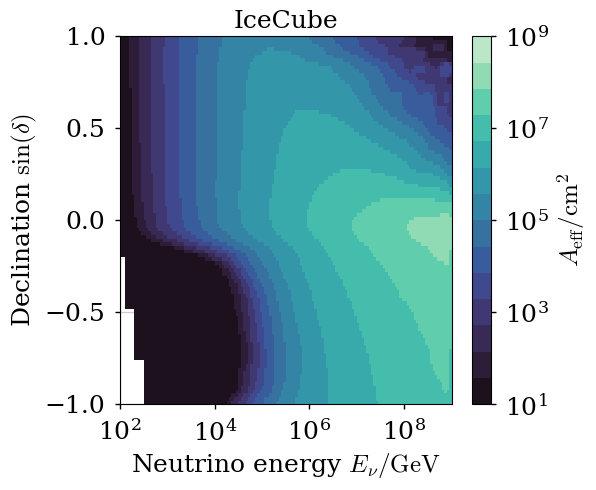

In [11]:
# IceCube only
fig, ax = plt.subplots(figsize=(6, 5), sharey=True)
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(p)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")
ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
fig.savefig(join(BASEPATH, "plots/aeff_full_IC.png"))


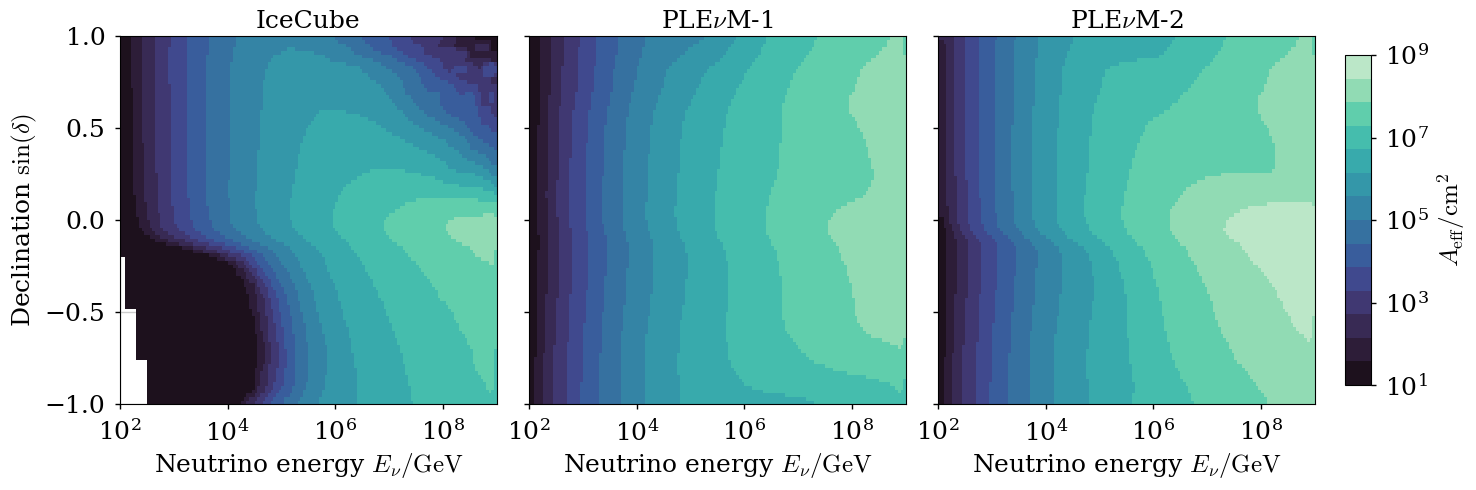

In [12]:
# IceCube, PLEnuM-1, -2
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-1"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-2"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_full_comparison_IC_PLENUM-1-2.pdf"))

In [13]:
aeff_2d_full.keys()

dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])

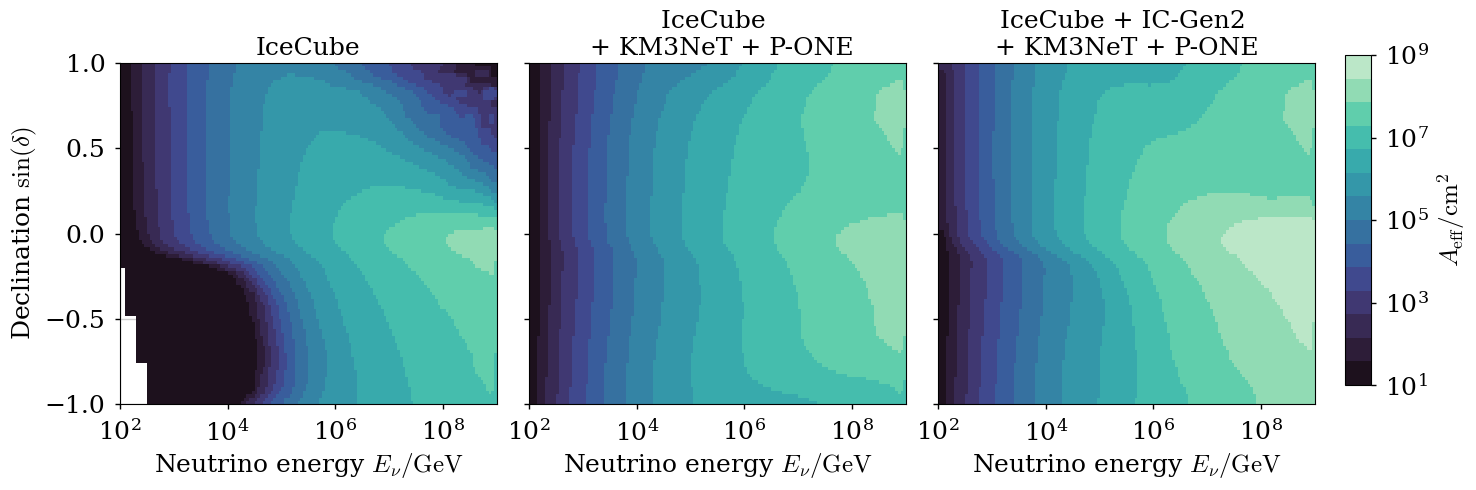

In [14]:
# IceCube, KM3NeT, P-ONE, Gen2
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title("IceCube \n + KM3NeT + P-ONE")
#ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo + aeff_2d_full["P-ONE"].histo + aeff_2d_full["KM3NeT"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
#ax.set_title(r"PLE$\nu$M-2")
ax.set_title("IceCube + IC-Gen2 \n + KM3NeT + P-ONE ")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo + aeff_2d_full["P-ONE"].histo + aeff_2d_full["KM3NeT"].histo + aeff_2d_full["Gen-2"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_full_comparison_IC_KM3_P1_G2.png"), dpi=200)

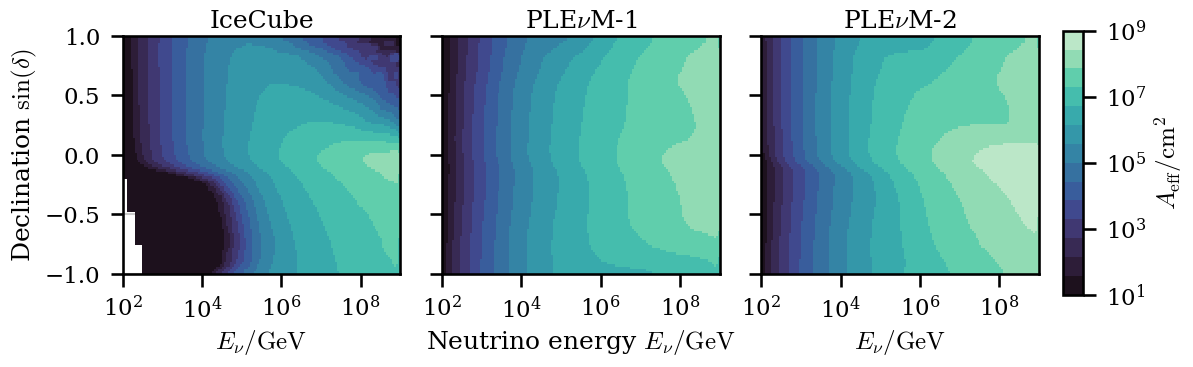

In [15]:
# IceCube, PLEnuM-1, -2, PNG
sns.set_context("talk")
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-1"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-2"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ii, ax in enumerate(axes):
    if ii==1:
        ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
    else:
        ax.set_xlabel(r"$E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_full_comparison_IC_PLENUM-1-2_poster.svg"))

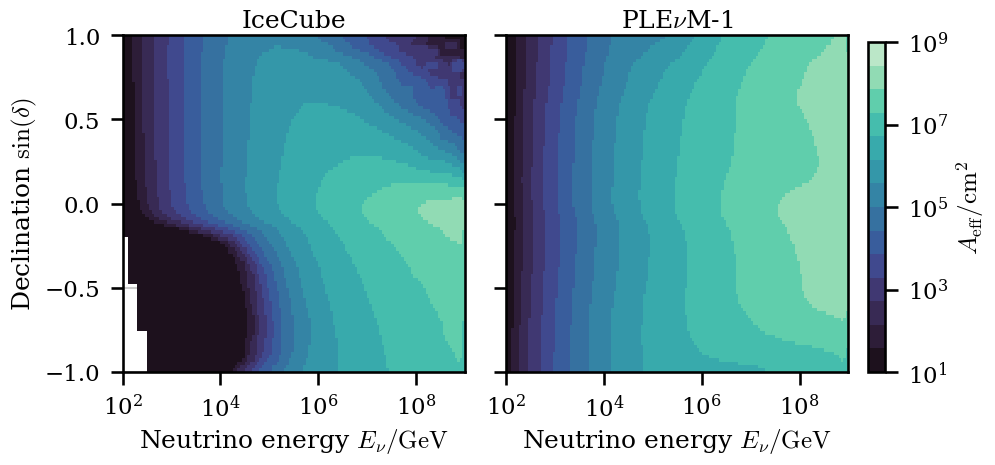

In [16]:
# IceCube, PLEnuM-1
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-1"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
    linewidth=0,
    rasterized=True,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_full_comparison_IC_PLENUM-1.pdf"))


In [17]:
#raise BaseException("Ö")

# Additional effective area checking plots

In [18]:
from tools import reset_palette

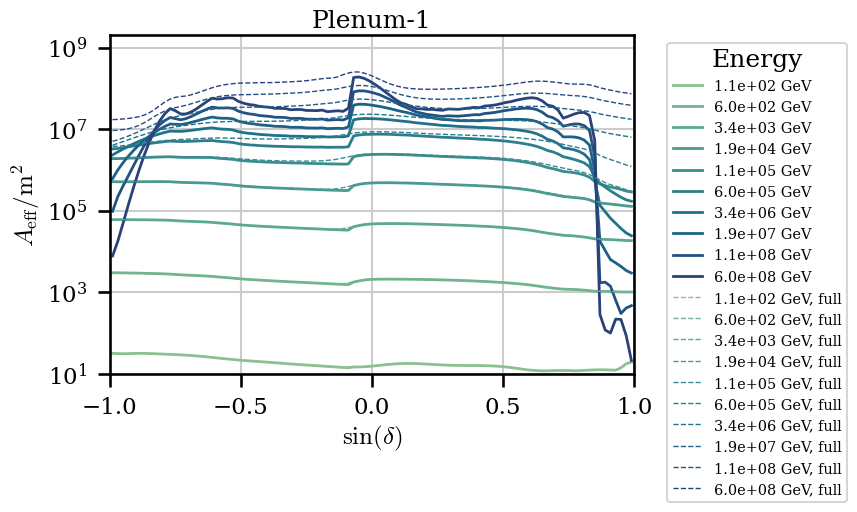

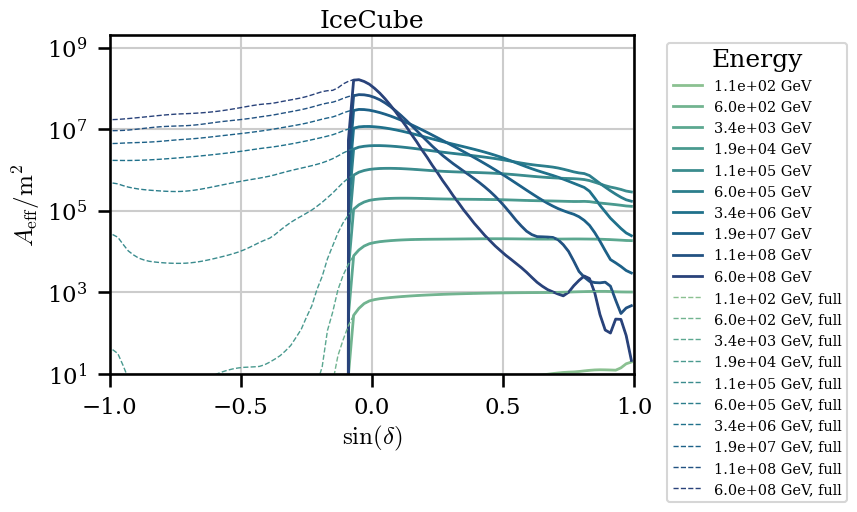

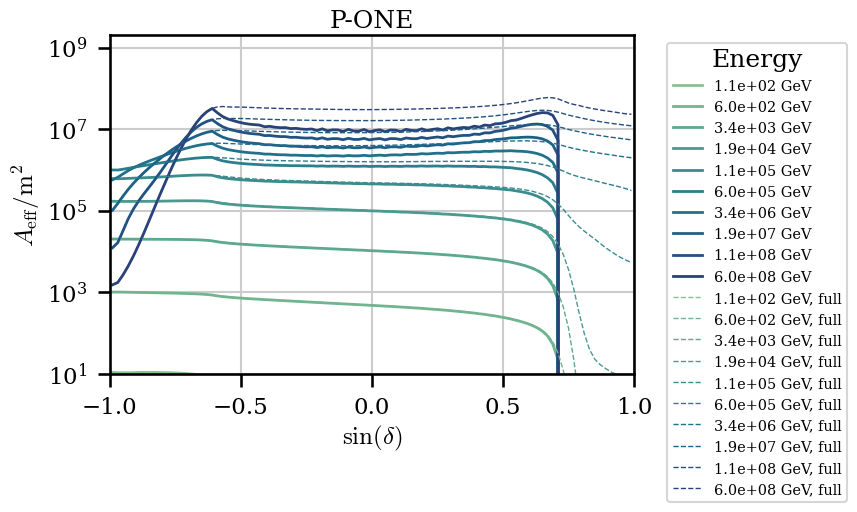

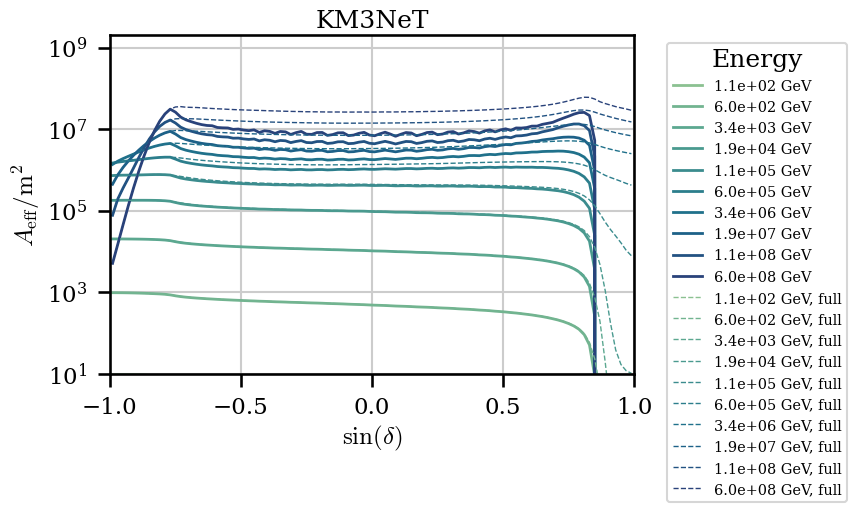

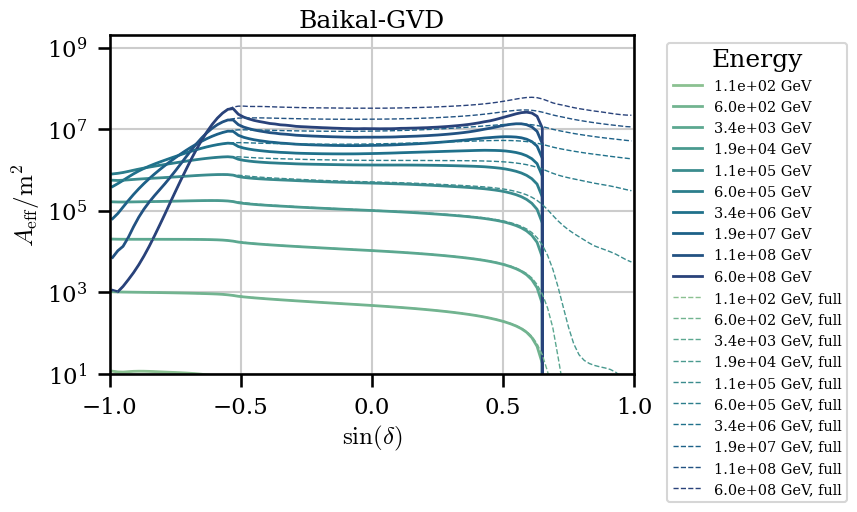

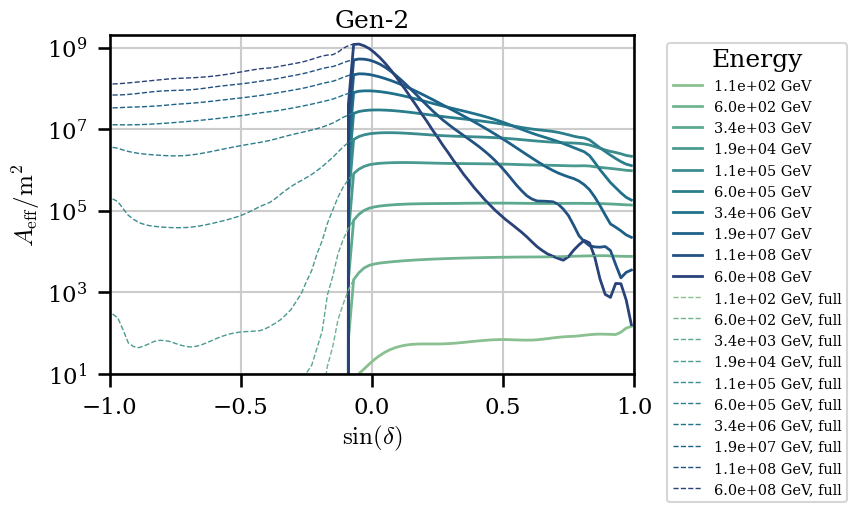

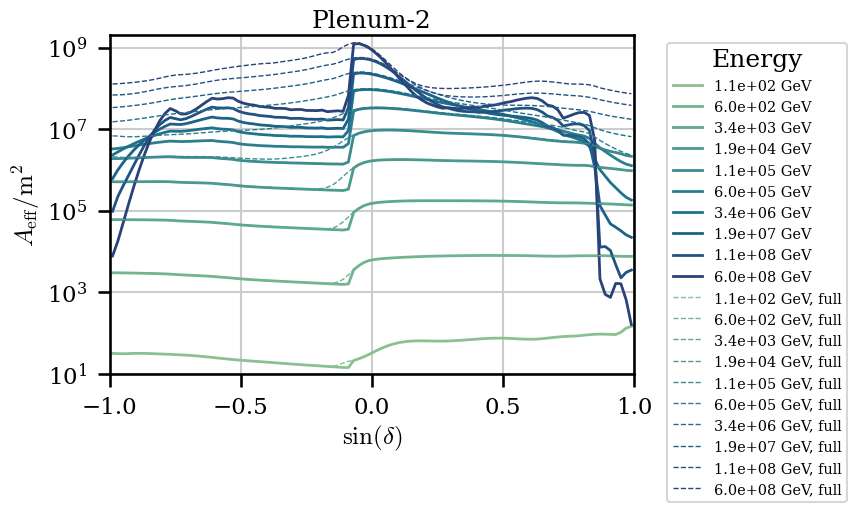

In [19]:
# slices in energy
factor = 15
nlines = len(emids) // factor + 1
reset_palette(nlines, sns)
mid_color = plt.rcParams["axes.prop_cycle"].by_key()["color"][nlines // 2]
for k in aeff_2d:
    plt.figure(figsize=(9, 5))
    for ie, ae in enumerate(aeff_2d[k].T()[::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV",
            ls="-",  # rotated
            lw=2,
        )
    for ie, ae in enumerate(aeff_2d_full[k].T()[::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV, full",
            ls="--",  # rotated
            lw=1,
        )
    plt.yscale("log")
    plt.title(k)

    plt.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", title="Energy", fontsize="xx-small"
    )
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(10, 2e9)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
